# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents **NeuroGraphNet**, a model that applies Graph Neural Networks to EEG data for seizure detection. The primary goal is to **compare the performance and interpretability of graph-based methods versus traditional deep learning approaches**. Through this comparison, we aim to demonstrate the advantages of incorporating brain connectivity information into the learning process.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [64]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader

from seiz_eeg.dataset import EEGDataset
from util.seeder import seed_everything

# set dataset root
DATA_ROOT = Path("./data")
seed_everything(42)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Dataset preprocessing

We apply a frequency-domain transformation to each EEG segment using the fft_filtering function. This function performs [band-pass filtering](https://en.wikipedia.org/wiki/Band-pass_filter) via the Fast Fourier Transform (FFT), isolating signal components within a specific frequency range—typically between 0.5 Hz and 30 Hz, which is commonly used in seizure detection research.

This process helps suppress noise and eliminate irrelevant frequency components, allowing the models to focus on the most informative parts of the signal. The filtered EEG segments are then loaded into memory as NumPy arrays using the `EEGDataset` class with optional prefetching enabled to speed up data access during training.

Also, we split the `label` attribute (which is a complex value formatted as follows):

```plaintext
<patient_id>_<session_no>_<clip_no>_<segment_no>
```


 into a pandas [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html) in order to easily 

In [ ]:
from util.filter import fft_filtering

# Load EEG segments, prepare data, and build dataset
clips_df = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_df = clips_df.dropna()

# Split id into multiple columns (multiindex)
def split_id(label):
    """Split the id into patient_id, session_id, and clip_no."""
    parts = label.split("_")
    if len(parts) == 4:
        return pd.Series(parts, index=["patient_id", "session_id", "clip_no", "segment_no"])
    else:
        raise ValueError(f"Unexpected id format: {label}")

# Apply the split and set MultiIndex
df = clips_df.reset_index()
split_cols = df["id"].apply(split_id)
df = df.join(split_cols)
df = df.set_index(["patient_id", "session_id", "clip_no", "segment_no"]).drop(columns=["id"])
df.index.set_names(["patient_id", "session_id", "clip_no", "segment_no"], inplace=True)
clips_df = df

# Build dataset + apply signal filtering
dataset_df = EEGDataset(
    clips_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

# example: load batches of data
# loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

## Dataset structure

Read more: 
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/clips.html>
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/dataset.html#seiz_eeg.dataset.EEGDataset>
- <https://seizure-eeg.readthedocs.io/en/latest/tutorials/1-events_and_dataframes.html> <-- most important

#### General information

In [79]:
clips_df.columns

Index(['label', 'start_time', 'end_time', 'date', 'sampling_rate',
       'signals_path'],
      dtype='object')

In [81]:
print("\n[Dataset information]")
print(f"- Clip length: {dataset_df.clip_lenght} [s]")
print(f"- Sampling rate: {dataset_df.s_rate} [Hz]")

print("\n[Dataset stats]")

# Calculate total patients
total_patients = clips_df.index.get_level_values("patient_id").nunique()

# Calculate total unique clips across all patients
# A clip is defined by a unique ('patient_id', 'clip_no') pair
total_clips = clips_df.groupby(level=['patient_id', 'clip_no']).ngroups

# Calculate total segments (assuming each row is a segment)
total_segments = len(clips_df) # Use len() for total rows

print(f"- Total rows (segments): {total_segments}")
print(f"- Total patients: {total_patients}")
# Total segments is just the number of rows
print(f"- Total segments: {total_segments}")
print(f"- Total unique clips: {total_clips}")

# Calculate average clips per patient
# Group by patient, count unique clips within each patient, then average
avg_clips_per_patient = clips_df.groupby(level='patient_id').apply(lambda x: x.index.get_level_values('clip_no').nunique()).mean()

# Calculate average segments per clip
# Group by unique clip (patient_id, clip_no), count segments (rows) in each group, then average
avg_segments_per_clip = clips_df.groupby(level=['patient_id', 'clip_no']).size().mean()

# Calculate average segments per patient
# Group by patient, count segments (rows) for each patient, then average
avg_segments_per_patient = clips_df.groupby(level="patient_id").size().mean()

print(f"- Avg. clips per patient: {avg_clips_per_patient}")
print(f"- Avg. segments per clip: {avg_segments_per_clip}")
print(f"- Avg. segments per patient: {avg_segments_per_patient}")


print("\n[Sensor information]")
channel_names = dataset_df.get_channels_names()
print(f"- Total channels: {len(channel_names)}")
print(f"- Channel names: {channel_names}")


[Dataset information]
- Clip length: 12.0 [s]
- Sampling rate: 250 [Hz]

[Dataset stats]
- Total rows (segments): 12993
- Total patients: 97
- Total segments: 12993
- Total unique clips: 167
- Avg. clips per patient: 1.7216494845360826
- Avg. segments per clip: 77.80239520958084
- Avg. segments per patient: 133.94845360824743

[Sensor information]
- Total channels: 19
- Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


In [ ]:
# Set useful variables
clip_length = dataset_df.clip_lenght # 12 seconds
sampling_rate = dataset_df.s_rate # 250 Hz
time_points = clip_length * sampling_rate # 12 s * 250 Hz = 3000 time points
num_channels = len(channel_names) # 19 channels (1 channel = 1 sensor)

**Sensor placement map**:

<img src="./assets/sensor_map.png" style="max-height: 500px;" />

## Exploratory data analysis

### Label distribution

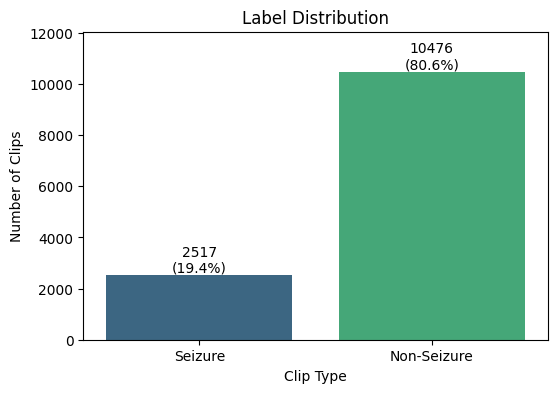

In [87]:
# Create a DataFrame for the label distribution plot
label_df = pd.DataFrame({'label': dataset_df.get_label_array()})
label_df['Clip Type'] = label_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

# Plot the label distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=label_df, x='Clip Type', palette='viridis', hue='Clip Type', dodge=False)
plt.title('Label Distribution')
plt.xlabel('Clip Type')
plt.ylabel('Number of Clips')

# Add counts and percentages on top of bars
total_count = len(label_df)
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{int(x)}\n({(100 * x / total_count):.1f}%)')

plt.ylim(0, label_df['Clip Type'].value_counts().max() * 1.15) # Adjust y-limit for text
plt.show()

### Seizure vs Non-Seizure Clips

Plotting Example Non-Seizure Clip with shape: (354, 19)


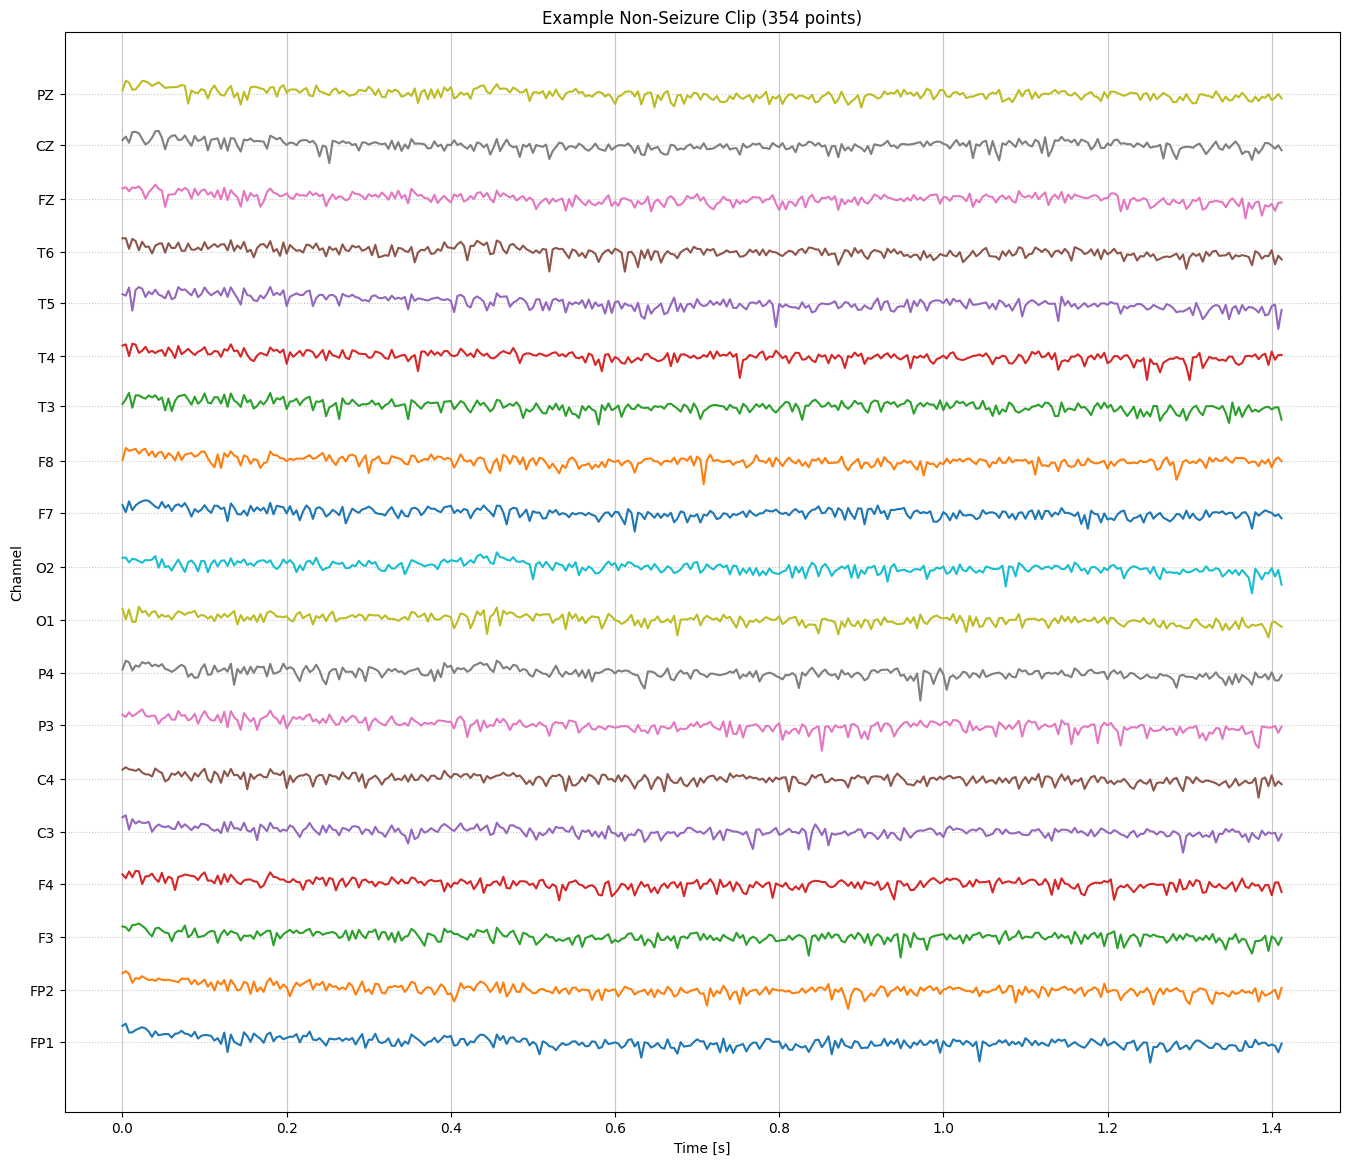

Plotting Example Seizure Clip with shape: (354, 19)


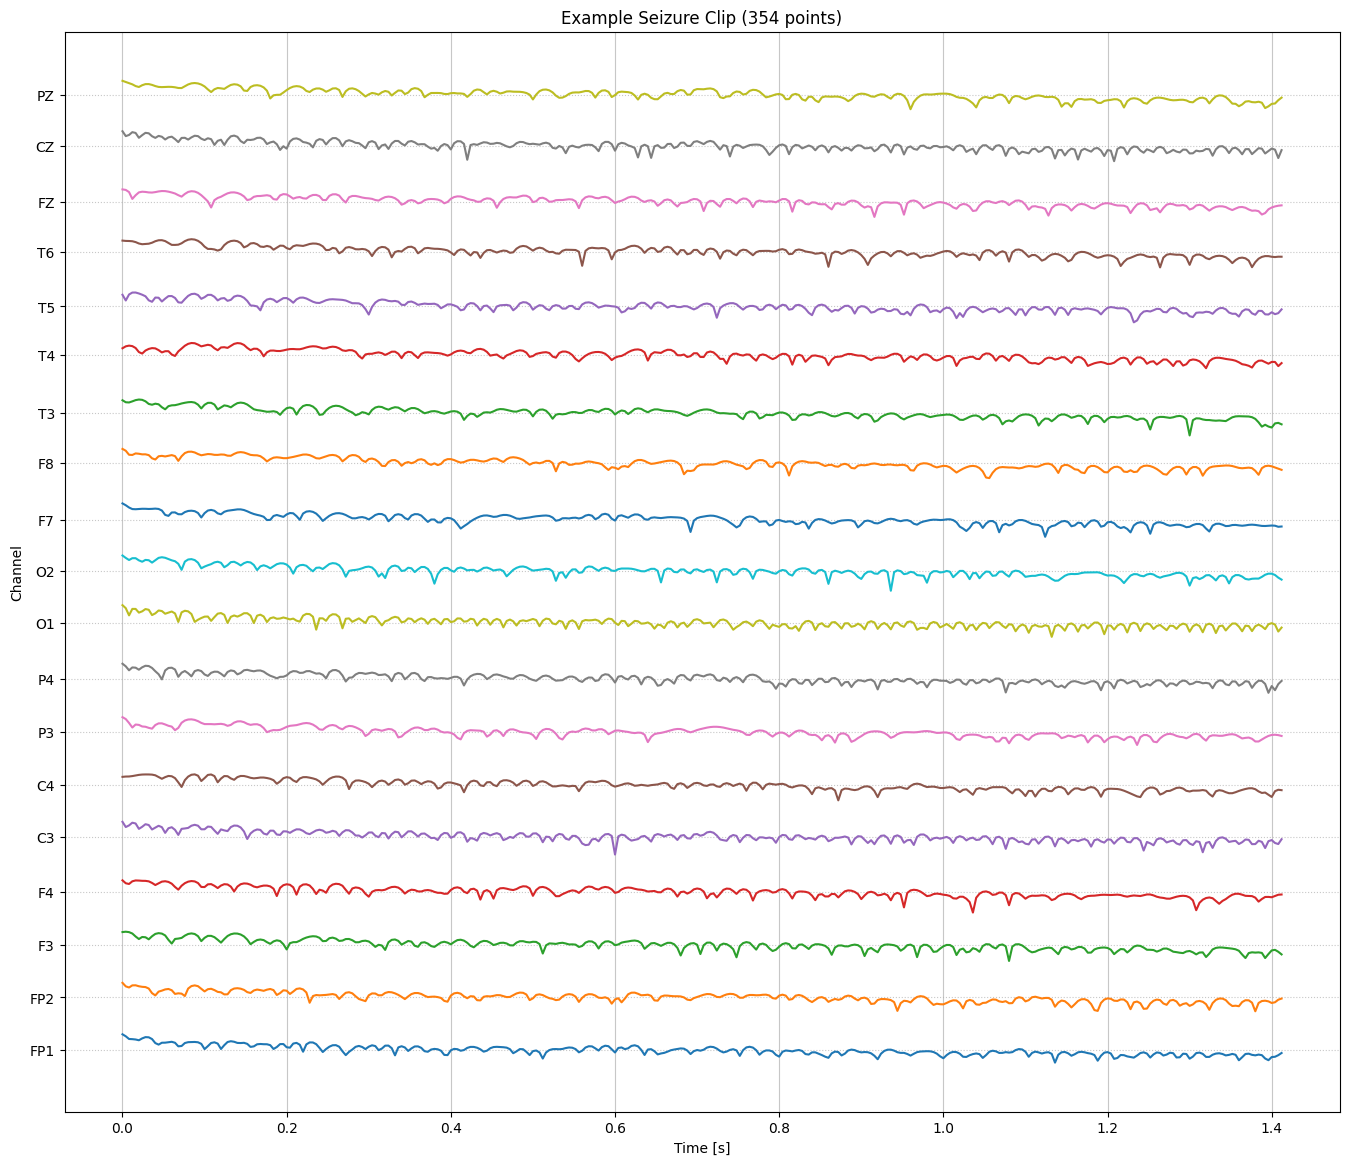

In [112]:
from util.plot import plot_eeg_clip

seizure_example = None
non_seizure_example = None

try:
    for x, y in dataset_df:
        if isinstance(x, np.ndarray) and x.ndim == 2:
            if y == 1 and seizure_example is None:
                seizure_example = x
            elif y == 0 and non_seizure_example is None:
                non_seizure_example = x
        # Stop if both examples are found
        if seizure_example is not None and non_seizure_example is not None:
            break
except TypeError as e:
    print(f"Error iterating through dataset: {e}")
    print("Please ensure 'dataset_tr' yields tuples of (signal_array, label).")
    seizure_example = None
    non_seizure_example = None


# Plot each example
if non_seizure_example is not None:
    plot_eeg_clip(non_seizure_example, "Example Non-Seizure Clip", sampling_rate, channel_names, offset_factor=10)
else:
    print("Could not find a non-seizure example clip to plot.")

if seizure_example is not None:
    plot_eeg_clip(seizure_example, "Example Seizure Clip", sampling_rate, channel_names, offset_factor=10)
else:
    print("Could not find a seizure example clip to plot.")
